In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/data.csv')

In [3]:
print(list(set(data['FieldID'])))

['SLSHDCRC', 'ACTSLS', 'FNLBSFRC', 'FNLRLLFRC', 'SLSBDG']


In [4]:
#Keep only actual sales and remove uneeded cols
def drop_cols_and_rows(data, cols_to_drop, row_to_keep):
    data = data[data['FieldID'].isin(row_to_keep)]
    data.drop(columns=cols_to_drop, axis=1, inplace=True)
    return data


#Rename cols
def col_renamer(data, rename_dict):
    for col_name in list(rename_dict.keys()):
        data.rename(columns={col_name:rename_dict[col_name]}, inplace=True)
    return data


#Select cols to keep
def col_selecter(data, selected_cols):
    data = data[selected_cols]
    return data


#Make artificial time index to pass into dataframe builer
def create_time_index(data):
    data['Date']= pd.to_datetime(data['Date'])
    data["Date"].dt.year * 12
    data["time_idx"] = data["Date"].dt.year * 12 + data["Date"].dt.month
    data["time_idx"] -= data["time_idx"].min()
    data["month"] = data.Date.dt.month.astype(str).astype("category")
    return data


#Create average cols for groups, remove volume under zero
def feature_engineering(data):
    data.Volume=data.Volume.mask(data.Volume.lt(0),0)
    data["log_volume"] = np.log(data.Volume + 1e-8)
    data["avg_volume_by_material"] = data.groupby(["time_idx", "ItemID"], observed=True).Volume.transform("mean")
    data["avg_volume_by_plant"] = data.groupby(["time_idx", "PlantID"], observed=True).Volume.transform("mean")
    data = data.assign(
                        timeseries=pd.factorize(list(zip(
                        *[data[c].values.tolist() for c in ['PlantID', 'ItemID']]
                        )))[0] + 1
                        )
    return data


#Only use if want to remove final time index
def remove_last_time_idx(data):
    data = data[data['time_idx'] != 35]
    return data


#Print summary of data
def data_summary(data):
    print('')
    print('Data size:')
    print(data.shape)
    print('Data columns:')
    print(data.columns.values)
    print('')


#Link all functions together
def preprocessing(data, cols_to_drop, row_to_keep, rename_dict, selected_cols):
    data_summary(data)
    data = drop_cols_and_rows(data, cols_to_drop, row_to_keep)
    data = col_renamer(data, rename_dict)
    data = col_selecter(data, selected_cols)
    data = create_time_index(data)
    data = feature_engineering(data)
    data = remove_last_time_idx(data)
    data_summary(data)
    return data

In [5]:
#Run function for preprocessing
COLS_TO_DROP = ['Field', 'UpdateBy', 'UpdateWhen', 'PlanningPeriod', 'ProductLineID', 'PeriodDiff']
ROW_TO_KEEP = ['ACTSLS', 'FNLRLLFRC']
RENAME_DICT = {'FieldContent':'Volume', 'PlannedPeriod':'Date'}
SELECTED_COLS = ['PlantID', 'ItemID', 'Volume', 'Date', 'FieldID']
non_corrected = preprocessing(data, COLS_TO_DROP, ROW_TO_KEEP, RENAME_DICT, SELECTED_COLS)
COLS_TO_DROP = ['Field', 'UpdateBy', 'UpdateWhen', 'PlanningPeriod', 'ProductLineID', 'PeriodDiff']
ROW_TO_KEEP = ['ACTSLS', 'SLSHDCRC']
RENAME_DICT = {'FieldContent':'Volume', 'PlannedPeriod':'Date'}
SELECTED_COLS = ['PlantID', 'ItemID', 'Volume', 'Date', 'FieldID']
corrected = preprocessing(data, COLS_TO_DROP, ROW_TO_KEEP, RENAME_DICT, SELECTED_COLS)


Data size:
(2961504, 11)
Data columns:
['ProductLineID' 'PlanningPeriod' 'ItemID' 'PlantID' 'PlannedPeriod'
 'PeriodDiff' 'FieldID' 'Field' 'FieldContent' 'UpdateBy' 'UpdateWhen']



C:\Users\Joseph.Amess\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Joseph.Amess\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(



Data size:
(1657032, 11)
Data columns:
['PlantID' 'ItemID' 'Volume' 'Date' 'FieldID' 'time_idx' 'month'
 'log_volume' 'avg_volume_by_material' 'avg_volume_by_plant' 'timeseries']


Data size:
(2961504, 11)
Data columns:
['ProductLineID' 'PlanningPeriod' 'ItemID' 'PlantID' 'PlannedPeriod'
 'PeriodDiff' 'FieldID' 'Field' 'FieldContent' 'UpdateBy' 'UpdateWhen']


Data size:
(1657032, 11)
Data columns:
['PlantID' 'ItemID' 'Volume' 'Date' 'FieldID' 'time_idx' 'month'
 'log_volume' 'avg_volume_by_material' 'avg_volume_by_plant' 'timeseries']



In [34]:
def timeseries_selection(data, num_zeros, num_to_print):
    timeseries_info = data.groupby('timeseries', as_index=False).agg(lambda x: x.eq(0).sum())[['Volume', 'timeseries']]
    selected_timeseries = np.array(list(timeseries_info[timeseries_info['Volume'] == num_zeros]['timeseries']))
    random_indices = np.random.randint(0, len(selected_timeseries), num_to_print)
    random_timeseries = selected_timeseries[random_indices]
    return random_timeseries


def plot(actual, forecast1, forecast2):
    plt.figure(figsize=(15, 9))
    plt.grid()
    plt.plot(actual['Date'], actual['Volume'], c='b', label='Actual Sales')
    plt.plot(forecast1['Date'], forecast1['Volume'], c='r', label='Forecast uncorrected')
    plt.plot(forecast2['Date'], forecast2['Volume'], c='g', label='Forecast corrected')
    plt.legend()
    plt.title('Actual sales and forecast')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.show()


def choose_forecasts(data1, data2, num_zeros, num_to_print, forecast_choice1, forecast_choice2):
    random_timeseries = timeseries_selection(data1, num_zeros, num_to_print)
    selected_data1 = data1[data1['timeseries'].isin(random_timeseries)]
    selected_data2 = data2[data2['timeseries'].isin(random_timeseries)]
    for timeseries in list(set(selected_data1['timeseries'])):
        timeseries_data1 = selected_data1[selected_data1['timeseries'] == timeseries]
        timeseries_data2 = selected_data2[selected_data2['timeseries'] == timeseries]
        ACTSLS = timeseries_data1[timeseries_data1['FieldID'] == 'ACTSLS'][['Date', 'Volume']]
        forecast2 = timeseries_data2[timeseries_data2['FieldID'] == forecast_choice2][['Date', 'Volume']]
        forecast1 = timeseries_data1[timeseries_data1['FieldID'] == forecast_choice1][['Date', 'Volume']]
        plot(ACTSLS, forecast1, forecast2)

In [38]:
NUM_TO_PRINT = 30
NUM_ZEROS = 2
FORECAST_CHOICE1 = 'FNLRLLFRC'
FORECAST_CHOICE2 = 'SLSHDCRC'
#choose_forecasts(non_corrected, corrected, NUM_ZEROS, NUM_TO_PRINT, FORECAST_CHOICE1, FORECAST_CHOICE2)

**Determine how many forecasts are zero when the last few months are zero**

In [46]:
def forecast_assessment(data):
    percent_zeros_list = []
    num_months = []
    for i in range(1, 10):
        num_months.append(i)
        timeseries_info = data.groupby('timeseries', as_index=False).agg(lambda x: x[35 - i:35].sum())[['Volume', 'timeseries']]
        ACTSLS_zeros = np.array(list(timeseries_info[timeseries_info['Volume'] == 0]['timeseries']))
        data_selected = data[data['timeseries'].isin(ACTSLS_zeros)]
        timeseries_info_2 = data_selected.groupby('timeseries', as_index=False).agg(lambda x: x[35::].sum())[['Volume', 'timeseries']]
        forecast_zeros = np.array(list(timeseries_info_2[timeseries_info_2['Volume'] == 0]['timeseries']))
        percent_zeros = 100 * (len(forecast_zeros) / len(ACTSLS_zeros))
        percent_zeros_list.append(percent_zeros)
    return percent_zeros_list, num_months


percent_zeros_list, num_months = forecast_assessment(corrected)

No handles with labels found to put in legend.


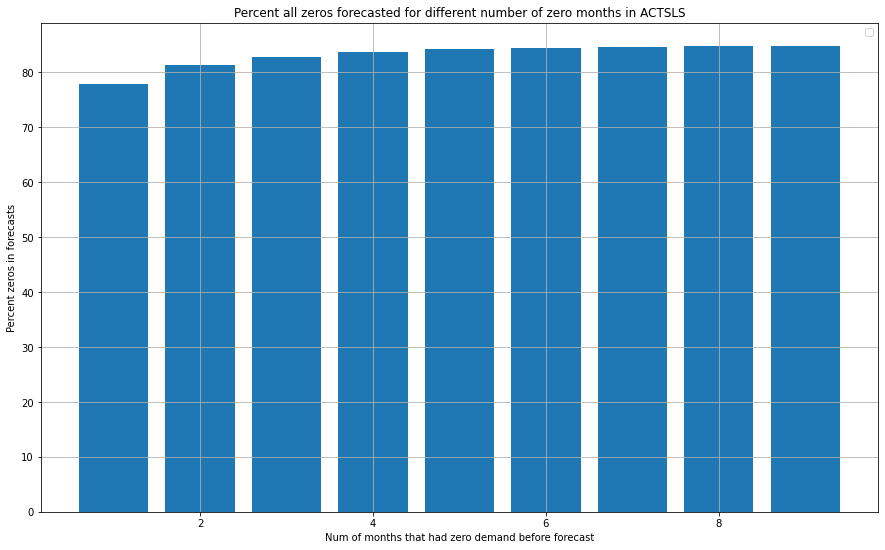

In [47]:
def plot_forecast_zeros(percent_zeros_list, num_months):
    plt.figure(figsize=(15, 9))
    plt.grid()
    plt.bar(num_months, percent_zeros_list)
    plt.legend()
    plt.title('Percent all zeros forecasted for different number of zero months in ACTSLS')
    plt.xlabel('Num of months that had zero demand before forecast')
    plt.ylabel('Percent zeros in forecasts')
    plt.show()


plot_forecast_zeros(percent_zeros_list, num_months)